In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
#root="/content/drive/MyDrive/proyecto_mineria_textos_turismo"
root='/content/drive/MyDrive/MineriaTextos/proyecto_mineria_textos_turismo'

In [ ]:
import random
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df=pd.read_csv(f"{root}/sentiment_augmentation.csv")
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df=df[["Title","Opinion","Label"]]
#df=df[["Opinion","Label"]]
df["Label"]=df["Label"]-1
df["Opinion"]=df["Opinion"].str.lower()
df["Title"]=df["Title"].str.lower()
df

,Title,Opinion,Label
0,"""¡momias, demasiado impresionante!""","""las momias están en muy buen estado de conser...",0
1,comida cara,tienen carteles con comida cortida de 40 y no ...,0
2,"""no coman ahí""","""creo que es muy insalubre, hay basura por tod...",0
3,"""momificado""","""para mí gusto no vale la pena... tristemente ...",0
4,"""incómodo y cero romántico""","""es un lugar poco interesante y que se conoce ...",0
...,...,...,...
5944,"""ansiedad""","""no me gustó ver las momias, me asustó, no es ...",1
5945,"""tema interesante / museo incompleto""",“fue muy decepcionante. el tema es súper inter...,1
5946,"""esperaba más""","""la verdad no vale mucho porque dejaron muy po...",1
5947,"""algo grotesco, pero algo interesante""","""no es mi tipo de museo. es grotesco, pero pod...",1


In [ ]:
label_dict=Counter(df.Label)
label_dict

Counter({0: 400, 1: 580, 2: 686, 3: 1595, 4: 2688})

In [ ]:
df['Opinion'] = df['Title'] + ' ' + df['Opinion']
df.head()

,Title,Opinion,Label
0,"""¡momias, demasiado impresionante!""","""¡momias, demasiado impresionante!"" ""las momia...",0
1,comida cara,comida cara tienen carteles con comida cortida...,0
2,"""no coman ahí""","""no coman ahí"" ""creo que es muy insalubre, hay...",0
3,"""momificado""","""momificado"" ""para mí gusto no vale la pena......",0
4,"""incómodo y cero romántico""","""incómodo y cero romántico"" ""es un lugar poco ...",0


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df["Opinion"], 
                                                  df["Label"], 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=df["Label"])

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train.index, 'data_type'] = 'train'
df.loc[X_val.index, 'data_type'] = 'val'

In [ ]:
Counter(y_train)

Counter({0: 320, 1: 464, 2: 549, 3: 1276, 4: 2150})

In [ ]:
Counter(y_val)

Counter({0: 80, 1: 116, 2: 137, 3: 319, 4: 538})

# Multilabel clasification

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train']["Opinion"].values,
    #df[df.data_type=='train'].iloc[:,:2].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val']["Opinion"].values, 
    #df[df.data_type=='val'].iloc[:,:2].values,
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].Label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].Label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
import torch.nn as nn

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.dropout = nn.Dropout(p=0.5, inplace=False)
model.bert.embeddings.dropout = nn.Dropout(p=0.3, inplace=False)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [ ]:
# model.bert.encoder.layer.modules

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
batch_size = 32
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
epochs = 10 # Despues de 5 epocas el modelo se sobre ajusta
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
train_loss=[]
validation_loss=[]

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    torch.save(model.state_dict(), f'{root}/models/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    train_loss.append(loss_train_avg)
    validation_loss.append(val_loss)


Epoch 1
Training loss: 1.2554943569554577
Validation loss: 1.0148949921131134
F1 Score (Weighted): 0.43410149954726607



Epoch 2
Training loss: 1.0209137057297981
Validation loss: 0.9309296294262535
F1 Score (Weighted): 0.5008700411008419



Epoch 3
Training loss: 0.9298226237297058
Validation loss: 0.8730007064969916
F1 Score (Weighted): 0.5671770576605754



Epoch 4
Training loss: 0.8607822904650797
Validation loss: 0.8459444712651404
F1 Score (Weighted): 0.5787009886358979



Epoch 5
Training loss: 0.809730586989614
Validation loss: 0.8402448531828428
F1 Score (Weighted): 0.596726782620838



Epoch 6
Training loss: 0.7677015230159632
Validation loss: 0.8394480253520765
F1 Score (Weighted): 0.5999441512466436



Epoch 7
Training loss: 0.7252511352100628
Validation loss: 0.8438582828170375
F1 Score (Weighted): 0.600417298138856



Epoch 8
Training loss: 0.6986496210498297
Validation loss: 0.83124352050455
F1 Score (Weighted): 0.6049238857317912



Epoch 9
Training loss: 0.6719791077127393
Validation loss: 0.8334330041941843
F1 Score (Weighted): 0.6059707779472989



Epoch 10
Training loss: 0.6637293280371084
Validation loss: 0.838241853996327
F1 Score (Weighted): 0.6128715348144567



In [ ]:
best_model=5
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)
model.load_state_dict(torch.load(f'{root}/models/finetuned_BERT_epoch_{best_model}.model', map_location=torch.device(device)))

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: 0
Accuracy: 18/80

Class: 1
Accuracy: 91/116

Class: 2
Accuracy: 68/137

Class: 3
Accuracy: 132/319

Class: 4
Accuracy: 416/538



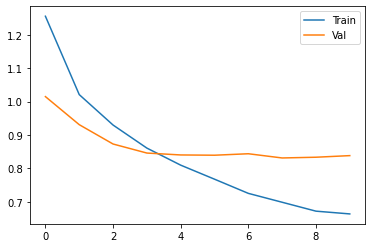

In [ ]:
plt.plot(train_loss, label="Train")
plt.plot(validation_loss,label="Val")
plt.legend()
plt.show()

In [ ]:
def MSE(yHat, y):
    return np.sum((yHat - y)**2) / y.size

def mse_per_class(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    y_preds=[]
    y_true=[]
    for label in np.unique(labels_flat):
        preds = preds_flat[labels_flat==label]
        true = labels_flat[labels_flat==label]
        mse=MSE(preds, true)
        print(f'\nClass: {label}')
        print("True:",Counter(true))
        print("Pred:",Counter(preds))
        print("MSE:",mse)
        y_preds.extend(preds)
        y_true.extend(true)
    print("\nMSE:", MSE(np.array(y_preds), np.array(y_true)))

In [ ]:
mse_per_class(predictions, true_vals)


Class: 0
True: Counter({0: 80})
Pred: Counter({1: 48, 0: 18, 2: 10, 4: 3, 3: 1})
MSE: 1.8125

Class: 1
True: Counter({1: 116})
Pred: Counter({1: 91, 2: 18, 3: 4, 0: 3})
MSE: 0.31896551724137934

Class: 2
True: Counter({2: 137})
Pred: Counter({2: 68, 3: 44, 4: 19, 1: 6})
MSE: 0.9197080291970803

Class: 3
True: Counter({3: 319})
Pred: Counter({4: 160, 3: 132, 2: 26, 1: 1})
MSE: 0.5956112852664577

Class: 4
True: Counter({4: 538})
Pred: Counter({4: 416, 3: 115, 2: 7})
MSE: 0.26579925650557623

MSE: 0.5386554621848739
